# Mold Price Estimation





## 0. Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Scikit-learn modules
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Pandas settings

# Show all rows & columns when printing
pd.set_option('display.max_rows', None)      # or a large number instead of None
pd.set_option('display.max_columns', None)   # same here

# Optional: widen the display so it doesn’t wrap
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)

## 1. Load Data


In [14]:
# 1. Read the semicolon-delimited file
df = pd.read_csv("Data.TR_BIG.csv", sep=";", decimal=",")

# 2. Drop the unnamed index column (the very first column)
df = df.drop(df.columns[0], axis=1)

# 3. Parse the delivery/validation date
df['V_D_Date'] = pd.to_datetime(df['V_D_Date'])

# 4. Quick sanity check
print(df.shape)    # how many rows, columns?
print(df.info())   # dtypes + missing counts
df.head()          # first 5 records

print(f"Rows: {len(df)}")

# get an Index of columns with exactly one unique value
const_cols = df.columns[df.nunique() == 1]

# print them
print(const_cols.tolist())

# drop id, unique value id because they are unique and are not useful for training
# drop date because it's ugly to work with it
# drop Injection_gate_A38 because nbre_total_points has the exact same values for each row
# drop Number_of_cavities_A22 because of the same reason
df = df.drop(columns=['id', 'unique_value_ID', 'V_D_Date', 'Injection_gate_A38', 'Number_of_cavities_A22'])



(643, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 71 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   ACHATS                                              643 non-null    float64       
 1   AJUSTAGE                                            643 non-null    float64       
 2   CN                                                  643 non-null    float64       
 3   ETUDES                                              643 non-null    float64       
 4   METHODES                                            643 non-null    float64       
 5   MOULE.CLEF.EN.MAIN1                                 643 non-null    float64       
 6   ST                                                  643 non-null    float64       
 7   Total_price                                         643 non-null    float64       
 8   

## 2. Clean & Filter data

In [15]:


# Replace string "NA" with real NaN
df = df.replace("NA", np.nan)

# Then drop any row containing a NaN
df = df.dropna(how="any").reset_index(drop=True)


# Compute z-scores for nbre total point column
z_ntp = zscore(df['Nbre_total_point'].fillna(df['Nbre_total_point'].median()))

# Keep only rows where both |z| ≤ 3
mask = (abs(z_ntp) <= 3)
df = df[mask]


df.info()

print(f"Rows after cleaning: {len(df)}")

equal_pairs = []
cols = list(df.columns)
for i, A in enumerate(cols):
    for B in cols[i+1:]:
        if df[A].equals(df[B]):
            equal_pairs.append((A, B))

print(equal_pairs)



<class 'pandas.core.frame.DataFrame'>
Index: 604 entries, 0 to 614
Data columns (total 66 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   ACHATS                                              604 non-null    float64
 1   AJUSTAGE                                            604 non-null    float64
 2   CN                                                  604 non-null    float64
 3   ETUDES                                              604 non-null    float64
 4   METHODES                                            604 non-null    float64
 5   MOULE.CLEF.EN.MAIN1                                 604 non-null    float64
 6   ST                                                  604 non-null    float64
 7   Total_price                                         604 non-null    float64
 8   N1                                                  604 non-null    float64
 9   N3  

In [16]:
# Check NaNs
df.isna().sum()    # how many NaNs per column

# Quick stats on continuous and count features
num_cols = ['Total_price', 'Mold_Volume_A4'] + [c for c in df.columns]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Total_price,604.0,0.279813,0.186396,0.000259,0.149871,0.240621,0.377749,0.974127
Mold_Volume_A4,604.0,0.117919,0.122791,0.000000,0.033922,0.082227,0.156835,0.705657
ACHATS,604.0,0.223721,0.178656,0.000000,0.096970,0.179201,0.304067,1.000000
AJUSTAGE,604.0,0.333359,0.182538,0.028417,0.214301,0.317286,0.417785,1.000000
CN,604.0,0.204877,0.160945,0.002087,0.093815,0.161291,0.271040,1.000000
ETUDES,604.0,0.342913,0.225174,0.000000,0.156095,0.317464,0.476685,1.000000
METHODES,604.0,0.251998,0.179153,0.000000,0.134383,0.195056,0.336750,1.000000
MOULE.CLEF.EN.MAIN1,604.0,0.379873,0.178513,0.019718,0.212274,0.387324,0.474849,1.000000
ST,604.0,0.224187,0.146521,0.000000,0.117678,0.190220,0.301569,1.000000
Total_price,604.0,0.279813,0.186396,0.000259,0.149871,0.240621,0.377749,0.974127


## 3. Split out target

In [17]:

y = df['Total_price']
X = df.drop(['Total_price'], axis=1)

# Create a held-out test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_feats = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_feats = X.select_dtypes(include=['object','category']).columns.tolist()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, categorical_feats)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 3. Set up the K-Fold splitter
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Run cross-validation (using RMSE as the scoring metric)
# scikit-learn’s “neg_root_mean_squared_error” returns negative values, so we take the negative of the mean
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

rmse_scores = -scores  # flip sign
print("5-Fold RMSE scores:", np.round(rmse_scores, 2))
print("Average RMSE:", np.round(rmse_scores.mean(), 2))
print("RMSE Std Dev:", np.round(rmse_scores.std(), 2))


5-Fold RMSE scores: [0.03 0.04 0.02 0.03 0.04]
Average RMSE: 0.03
RMSE Std Dev: 0.01


|--- ST <= 0.33
|   |--- AJUSTAGE <= -0.46
|   |   |--- ST <= -0.79
|   |   |   |--- AJUSTAGE <= -1.28
|   |   |   |   |--- ST <= -0.99
|   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |--- ST >  -0.99
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- AJUSTAGE >  -1.28
|   |   |   |   |--- ETUDES <= -0.28
|   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |--- ETUDES >  -0.28
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |--- ST >  -0.79
|   |   |   |--- ACHATS <= -0.56
|   |   |   |   |--- ETUDES <= -0.61
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- ETUDES >  -0.61
|   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- ACHATS >  -0.56
|   |   |   |   |--- ACHATS <= -0.06
|   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |--- ACHATS >  -0.06
|   |   |   |   |   |--- truncated branch of depth 5
|   |--- AJUSTAGE >  -0.46
|   |   |--- ETUDES <= 1.10
| 

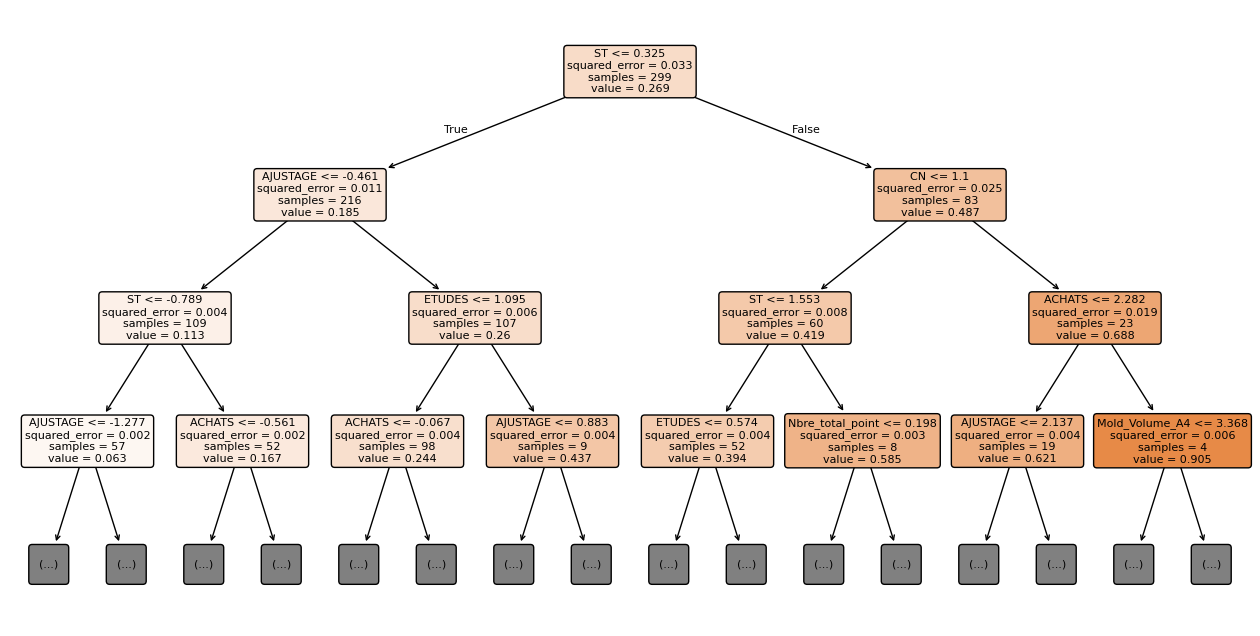

In [18]:
# 1. Fit the pipeline on the full dataset
pipeline.fit(X_train, y_train)

# 2. Extract the fitted forest
rf = pipeline.named_steps['regressor']

# 3. Grab the very first tree
tree0 = rf.estimators_[0]

# 4. (Optional) Build a list of feature-names after one-hot encoding
feature_names = (
    numeric_feats
    + list(
        pipeline
        .named_steps['preprocessing']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_feats)
    )
)



## 4. Hyperparameter Tuning

In [19]:
# Pick sensible ranges for your random forest

param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth':    [None, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features':      ['sqrt', 'log2', 0.5]  # no more 'auto'
  }

# Wrap in Grid search CV

grid_search = GridSearchCV(
    estimator   = pipeline,        # pipeline from before
    param_grid  = param_grid,
    cv          = KFold(n_splits=5, shuffle=True, random_state=42),
    scoring     = 'neg_root_mean_squared_error',
    n_jobs      = -1,
    verbose     = 2
)

grid_search.fit(X_train, y_train)  # fit on the full dataset (CV inside)

# Inspect best parameter
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'regressor__max_depth': 10, 'regressor__max_features': 0.5, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}
Best CV RMSE: 0.030449083768499707


Evaluate Model Performance:

In [20]:
#mean_price = y.mean()
#price_range = y.max() - y.min()

#rel_rmse_mean  =  rmse_scores.mean() / mean_price
#rel_rmse_range =  rmse_scores.mean() / price_range

#print("Absolute error:" + rel_rmse_mean)
#print("Relative error:" + rel_rmse_range)

Evaluate on a held out test split

In [21]:


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
print("Test R²:", r2_score(y_test, y_test_pred))

Test RMSE: 0.029626631713914726
Test R²: 0.9740715552491334


/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Compare with other algorithms

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}

gb_search = GridSearchCV(
    gb_pipeline, gb_param_grid,
    cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
gb_search.fit(X, y)
print("GB Best RMSE:", -gb_search.best_score_)


GB Best RMSE: 0.02258388457164225


Feature importance and interpretability




ST                      0.297878
AJUSTAGE                0.290758
METHODES                0.138837
ETUDES                  0.080121
ACHATS                  0.074310
CN                      0.051062
Mold_Volume_A4          0.040307
Nbre_mvt_meca_simple    0.004963
MOULE.CLEF.EN.MAIN1     0.004306
Cold.injection.sprue    0.002706
dtype: float64


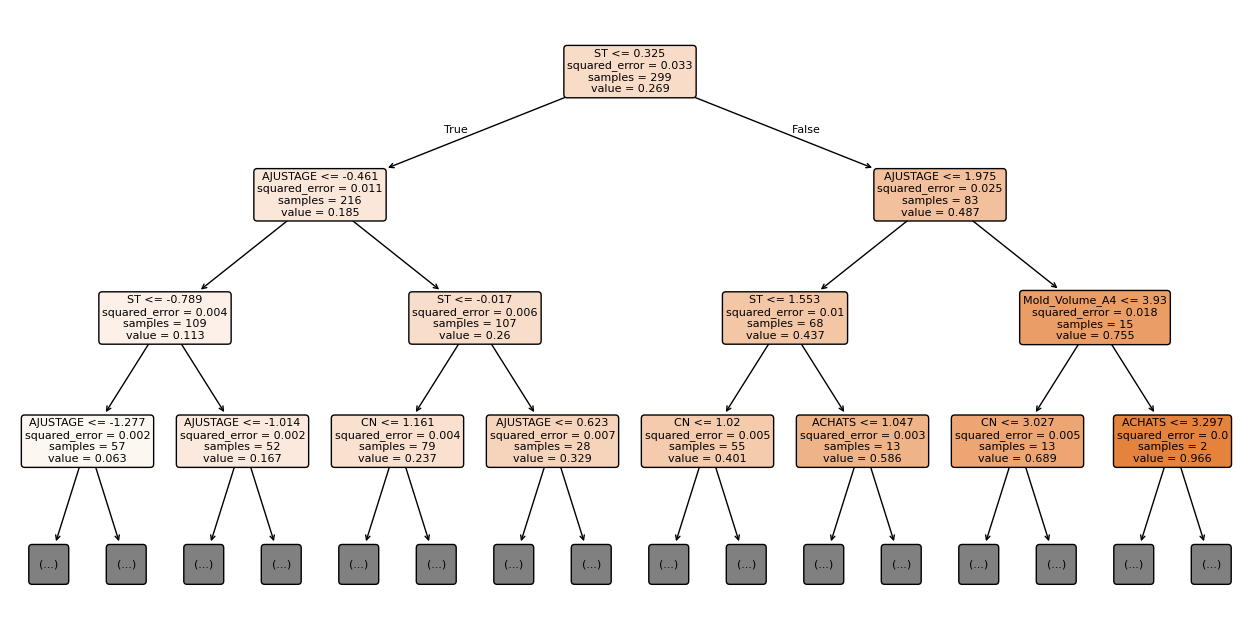

/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users

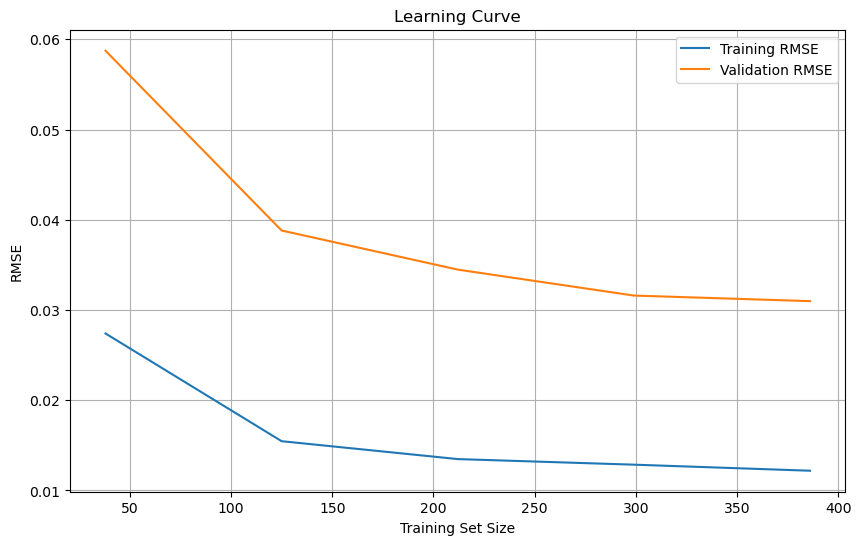

In [29]:
import pandas as pd

# Extract feature names after one-hot encoding
feature_names = (
    numeric_feats +
    list(grid_search.best_estimator_
             .named_steps['preprocessing']
             .named_transformers_['cat']
             .get_feature_names_out(categorical_feats))
)

importances = best_model.named_steps['regressor'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(10))





residual analysis

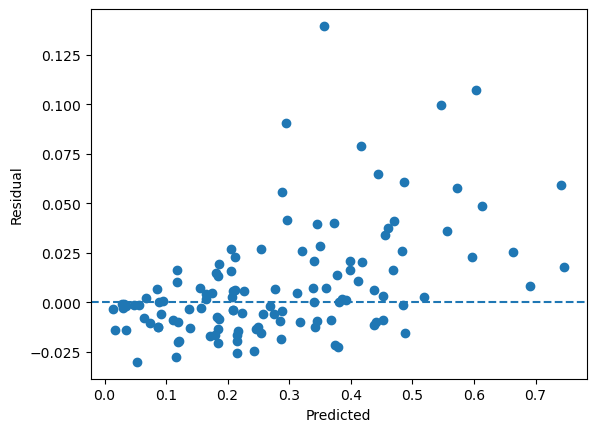

/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users

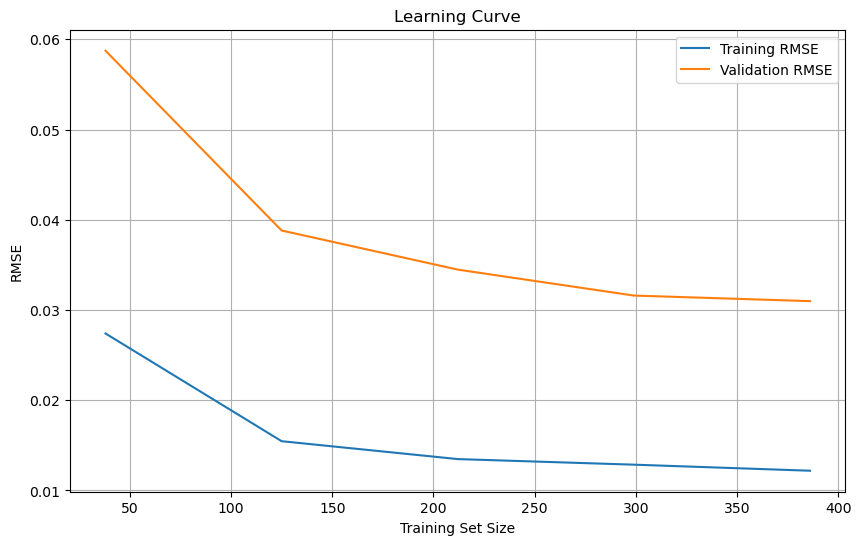

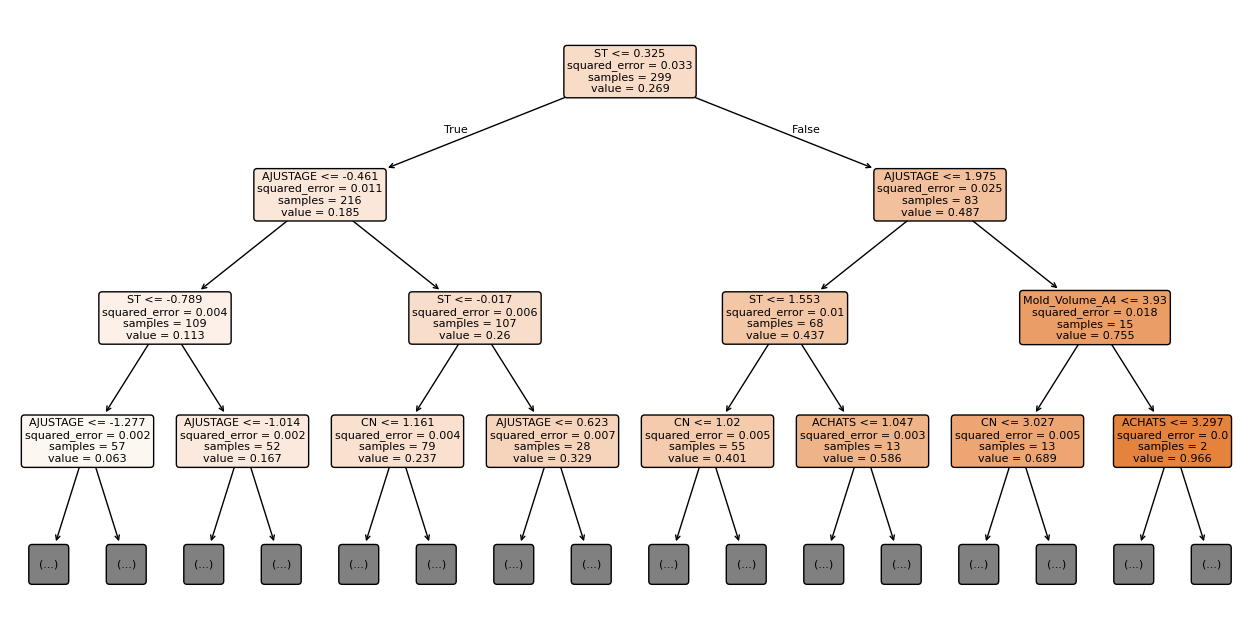

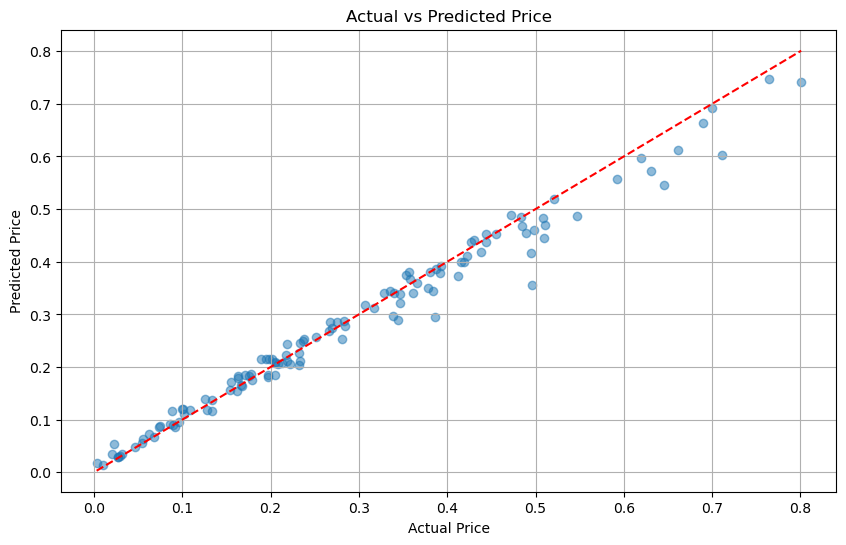

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [31]:
import matplotlib.pyplot as plt

# plot residuals
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()


# plot learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training RMSE')
plt.plot(train_sizes, test_scores_mean, label='Validation RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

# plot the tree of the best model
plt.figure(figsize=(16, 8))
from sklearn.tree import plot_tree
plot_tree(
    best_model.named_steps['regressor'].estimators_[0],
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8
)
plt.show()

# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.grid()
plt.show()


In [35]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 0.12
Mean Squared Error (MSE): 0.00088
Root Mean Squared Error (RMSE): 0.03
R² Score: 0.97


/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Test with External Test Data

In [34]:
# Load the test dataset
test_df = pd.read_csv("Data.TE_BIG.csv", sep=";", decimal=",")
test_df = test_df.drop(columns=['id', 'unique_value_ID', 'V_D_Date', 'Injection_gate_A38', 'Number_of_cavities_A22'])
test_df = test_df.replace("NA", np.nan).dropna(how="any").reset_index(drop=True)

# Preprocess the test dataset
X_test_final = test_df.drop(['Total_price'], axis=1)
y_test_final = test_df['Total_price']

# Train the model on the entire training dataset
pipeline.fit(X, y)

# Predict on the test dataset
y_test_pred_final = pipeline.predict(X_test_final)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_final, y_test_pred_final)
mape = mean_absolute_percentage_error(y_test_final, y_test_pred_final)
mse = mean_squared_error(y_test_final, y_test_pred_final)
rmse = mean_squared_error(y_test_final, y_test_pred_final, squared=False)
r2 = r2_score(y_test_final, y_test_pred_final)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 0.10
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.03
R² Score: 0.97


/Users/laurensheithecker/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
